## Logistic Regression

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [3]:
bc_data = datasets.load_breast_cancer()

X = bc_data.data
y = bc_data.target.astype("float")
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42)

In [8]:
class LogisticRegressionClassifier:
    def __init__(self, l2=0., lr=0.003):
        self.l2 = l2
        self.lr = lr
        self.theta = None

    @staticmethod
    def sigmoid(x):
        return 1. / (1 + np.exp(-x))

    def make_datagen(self, X, y=None, batch_size=16):
        for i in range(0, len(X), batch_size):
            x_batch = X[i:i+batch_size]
            if y is not None:    # for training
                y_batch = y[i:i+batch_size]
                assert x_batch.shape[0] == y_batch.shape[0]
                yield x_batch, y_batch
            else:    # for prediction
                yield x_batch

    def predict_batch(self, x):
        h = np.dot(x, self.theta)
        return self.sigmoid(h)

    def compute_loss(self, h, y, eps=1e-8):
        m = h.shape[0]
        # without eps log(0) will eval to nan
        j = (1.0 / m) * np.sum(-y * np.log(h + eps) - (1.0 - y) * np.log(1.0 - h + eps))
        j += (self.l2 / 2.) * np.linalg.norm(self.theta, 2)    # l2 regularization
        return j

    def compute_grad(self, x, h, y):
        m = h.shape[0]
        return (1. / m) * np.dot(x.T, (h - y))

    def update_weights(self, grad):
        self.theta = self.theta - self.lr * grad

    def shuffle_data(self, X, y):
        # concat x and y to shuffle together
        x_temp = np.concatenate([X, np.expand_dims(y, axis=1)], axis=1)
        np.random.shuffle(x_temp)
        return x_temp[:, :-1], np.squeeze(x_temp[:, -1])

    def fit(self, X_train, y_train, epochs=100, batch_size=16, tol=0.0001, shuffle=True):
        epoch = 0
        losses = []
        epoch_loss = float("inf")    # to check convergence
        self.theta = np.random.rand(X_train.shape[1])    # random init
        while epoch < epochs and epoch_loss > tol:
            datagen = self.make_datagen(X_train, y_train, batch_size=batch_size)    # yield batches of data
            epoch_losses = []    # to avg losses across epoch
            for i, (x, y) in enumerate(datagen):
                y_pred = self.predict_batch(x)
                loss = self.compute_loss(y_pred, y)
                epoch_losses.append(loss)

                grad = self.compute_grad(x, y_pred, y)
                self.update_weights(grad)

                epoch_loss = sum(epoch_losses)/(i+1)    # avg. epoch loss
            losses.append(epoch_loss)

            if shuffle:    # shuffle at epochs end
                X_train, y_train = self.shuffle_data(X_train, y_train)

            epoch += 1

        return losses

    def predict(self, X_test, batch_size=16):
        assert self.theta is not None    # will fail if fit hasn't been called
        datagen = self.make_datagen(X_test, batch_size=batch_size)
        y_ret = []
        for i, x in enumerate(datagen):
            y_pred = self.predict_batch(x)
            # threshold at 0.5
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            y_ret.append(y_pred)

        return np.concatenate(y_ret, axis=0)

/home/alex/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


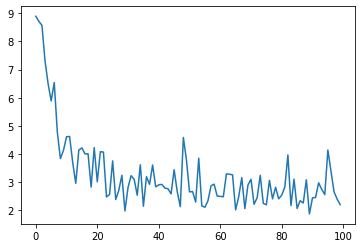

In [9]:
logreg_clf = LogisticRegressionClassifier(l2=0.001)
losses = logreg_clf.fit(X_train, y_train, epochs=100, batch_size=16)
plt.plot(range(len(losses)), losses)

In [10]:
y_r = logreg_clf.predict(X_test)

/home/alex/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


In [11]:
f1_score(y_test, y_r, average="micro")

0.5585106382978723